In [1]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from google.colab import files
uploaded=files.upload()

Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn.csv


In [10]:
df=pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
print(df.head())
print(df.info())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [11]:
# Step 3: Data Preprocessing
# Drop customerID as it's not useful
df.drop("customerID", axis=1, inplace=True)

# Convert TotalCharges to numeric (coerce errors to NaN)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')

# Handle missing values
df.dropna(inplace=True)

# Encode categorical variables
for col in df.select_dtypes(include="object").columns:
    if df[col].nunique() == 2:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
    else:
        df = pd.get_dummies(df, columns=[col], drop_first=True)

In [12]:
# Step 4: Split the Data
X = df.drop("Churn", axis=1)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
# Step 5: Decision Tree Model
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
dt_preds = dt.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, dt_preds))
print("Classification Report for Decision Tree:\n", classification_report(y_test, dt_preds))


Decision Tree Accuracy: 0.7242359630419332
Classification Report for Decision Tree:
               precision    recall  f1-score   support

           0       0.82      0.80      0.81      1033
           1       0.48      0.51      0.49       374

    accuracy                           0.72      1407
   macro avg       0.65      0.65      0.65      1407
weighted avg       0.73      0.72      0.73      1407



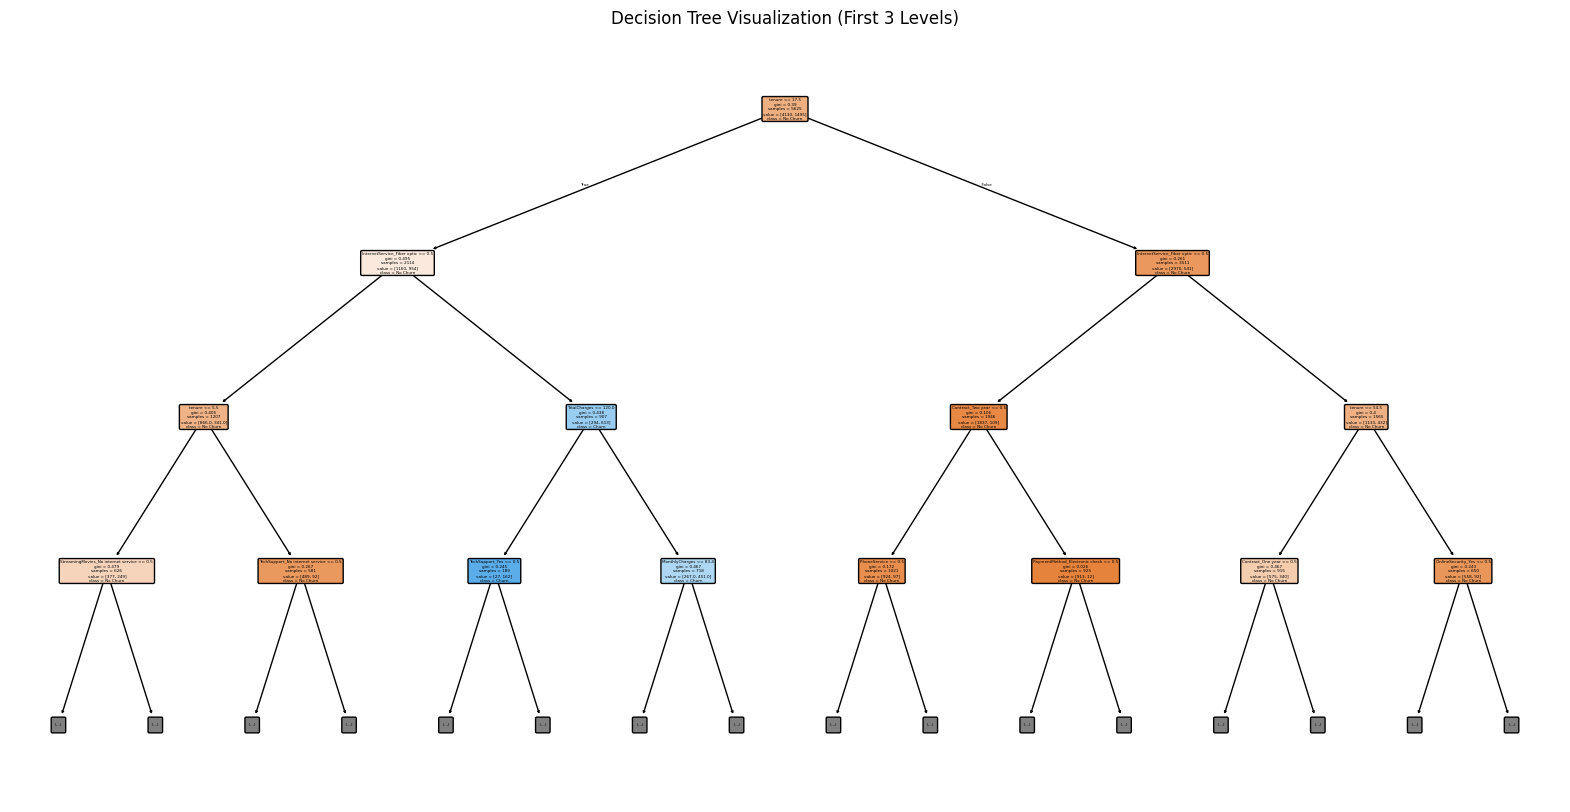

In [15]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20,10))
plot_tree(dt, feature_names=X.columns, class_names=["No Churn", "Churn"], filled=True, rounded=True, max_depth=3)
plt.title("Decision Tree Visualization (First 3 Levels)")
plt.show()

In [16]:
pip install graphviz

In [17]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(
    dt,
    out_file=None,
    feature_names=X.columns,
    class_names=["No Churn", "Churn"],
    filled=True,
    rounded=True,
    special_characters=True,
    max_depth=3
)
graph = graphviz.Source(dot_data)
graph.render("decision_tree_telco", format='png', cleanup=False)
graph.view()  # opens the image

'decision_tree_telco.pdf'

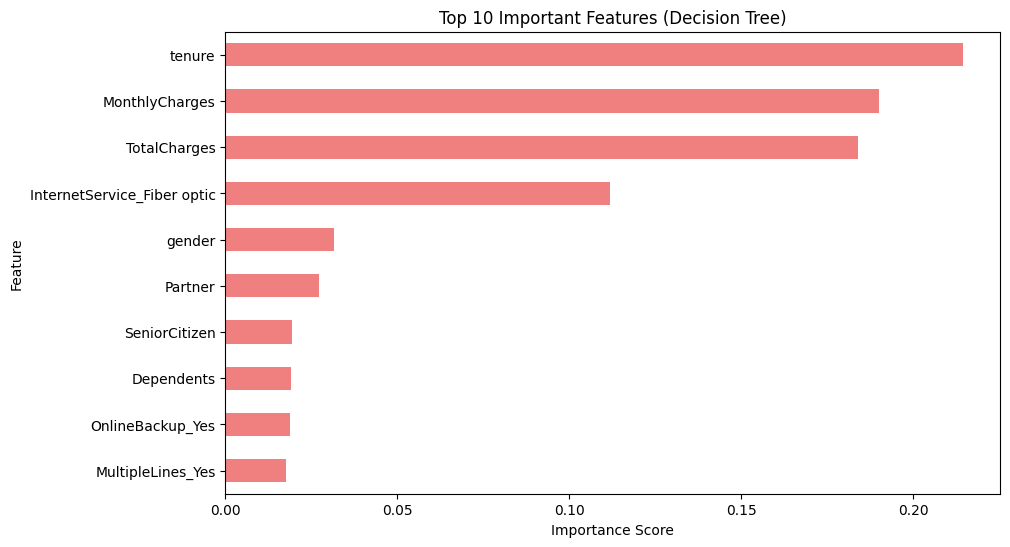

In [21]:
# Decision Tree Feature Importances
dt_feat_importance = pd.Series(dt.feature_importances_, index=X.columns)

# Plot Top 10
dt_feat_importance.nlargest(10).sort_values().plot(kind='barh', figsize=(10, 6), color='lightcoral')
plt.title("Top 10 Important Features (Decision Tree)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

In [14]:
# Step 6: Random Forest Model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
rf_preds = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, rf_preds))
print("Classification Report for Random Forest:\n", classification_report(y_test, rf_preds))


Random Forest Accuracy: 0.7882018479033405
Classification Report for Random Forest:
               precision    recall  f1-score   support

           0       0.82      0.91      0.86      1033
           1       0.64      0.46      0.54       374

    accuracy                           0.79      1407
   macro avg       0.73      0.68      0.70      1407
weighted avg       0.77      0.79      0.78      1407



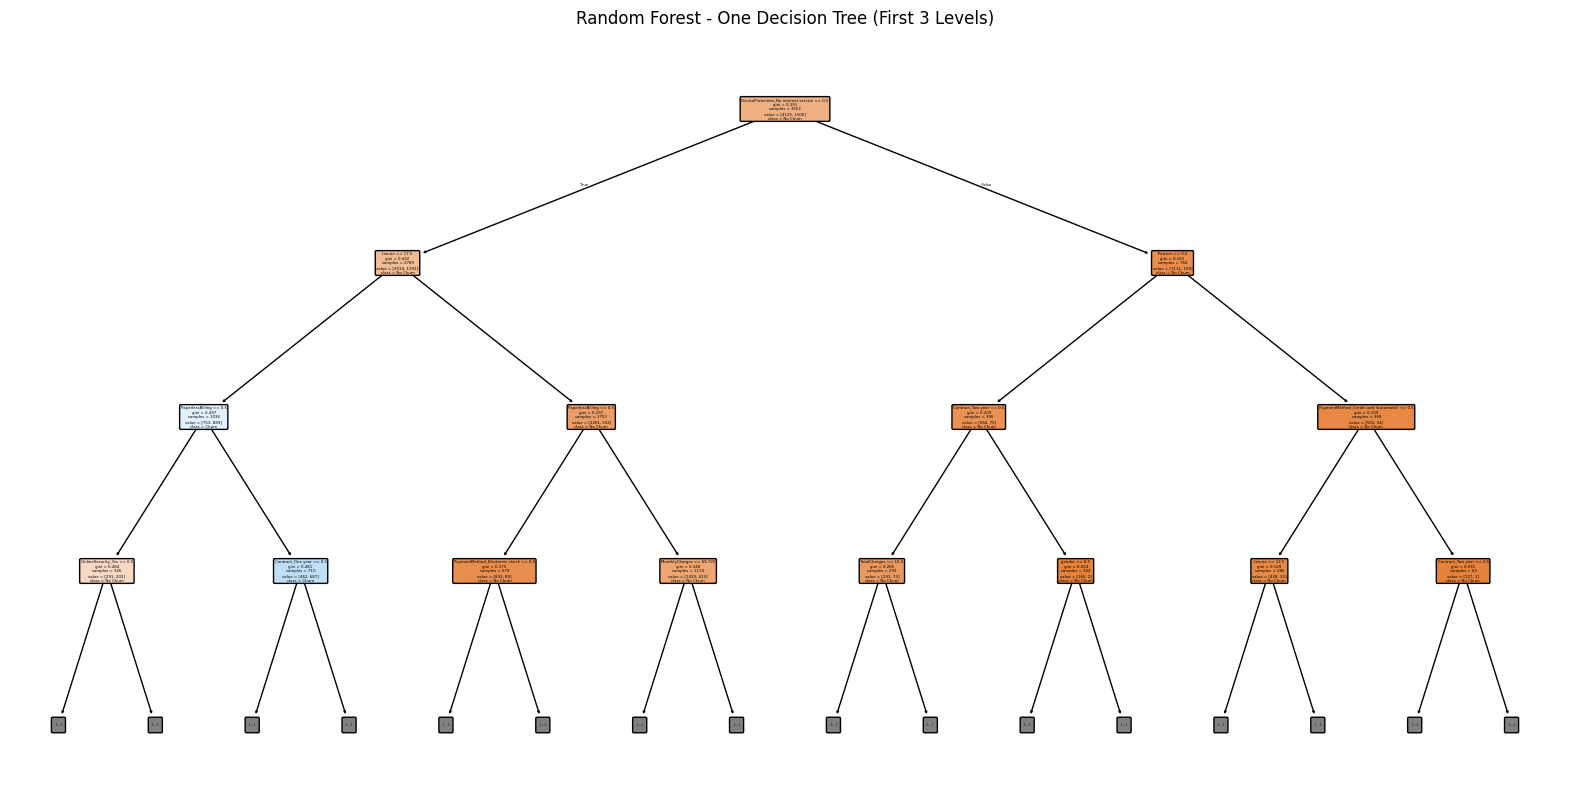

In [18]:
# Select one tree from the forest (e.g., the first one)
estimator = rf.estimators_[0]

# Plot the tree
plt.figure(figsize=(20, 10))
plot_tree(estimator,
          feature_names=X.columns,
          class_names=["No Churn", "Churn"],
          filled=True,
          rounded=True,
          max_depth=3)  # Limit depth for readability
plt.title("Random Forest - One Decision Tree (First 3 Levels)")
plt.show()

In [19]:
print(f"Number of trees in the forest: {len(rf.estimators_)}")

Number of trees in the forest: 100


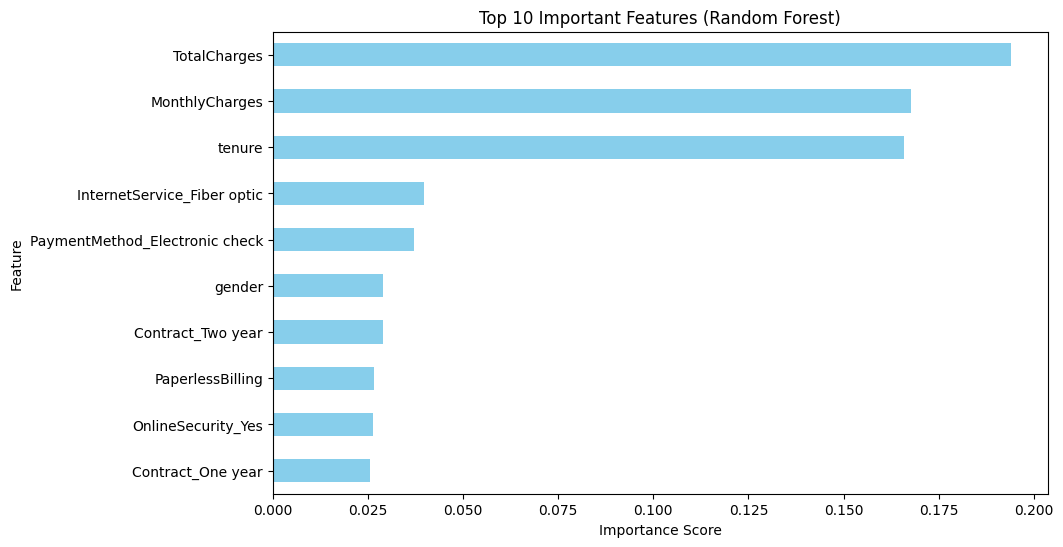

In [20]:
# Create a DataFrame with feature importances
feat_importance = pd.Series(rf.feature_importances_, index=X.columns)
feat_importance.nlargest(10).sort_values().plot(kind='barh', figsize=(10, 6), color='skyblue')
plt.title("Top 10 Important Features (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

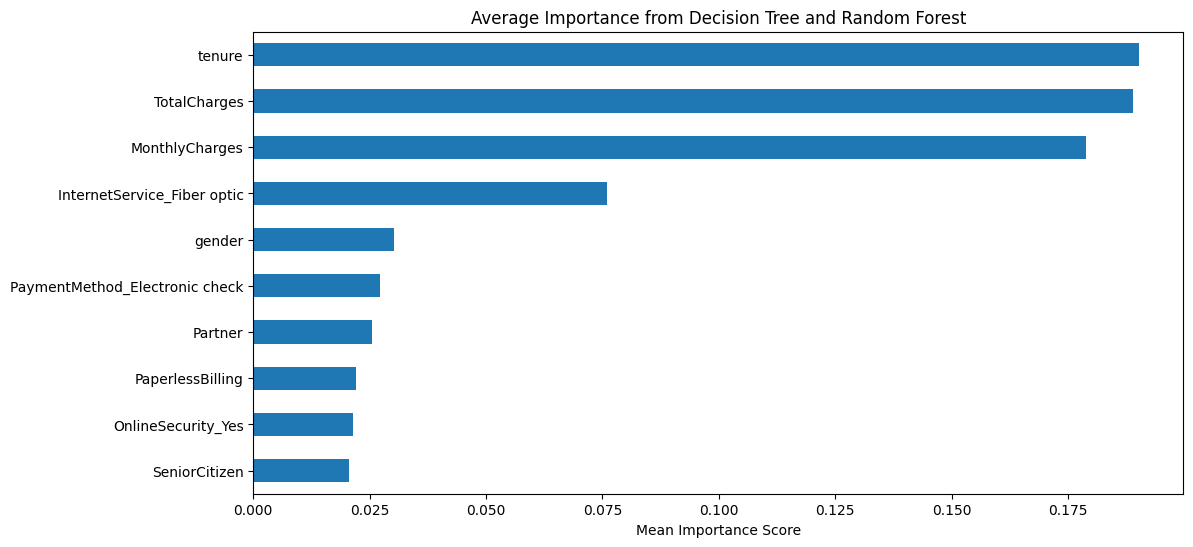

In [22]:
# Combine both into a DataFrame
importances_df = pd.DataFrame({
    'DecisionTree': dt.feature_importances_,
    'RandomForest': rf.feature_importances_
}, index=X.columns)

# Plot side-by-side bars for top 10 features
importances_df.mean(axis=1).nlargest(10).sort_values().plot(kind='barh', figsize=(12, 6))
plt.title("Average Importance from Decision Tree and Random Forest")
plt.xlabel("Mean Importance Score")
plt.show()

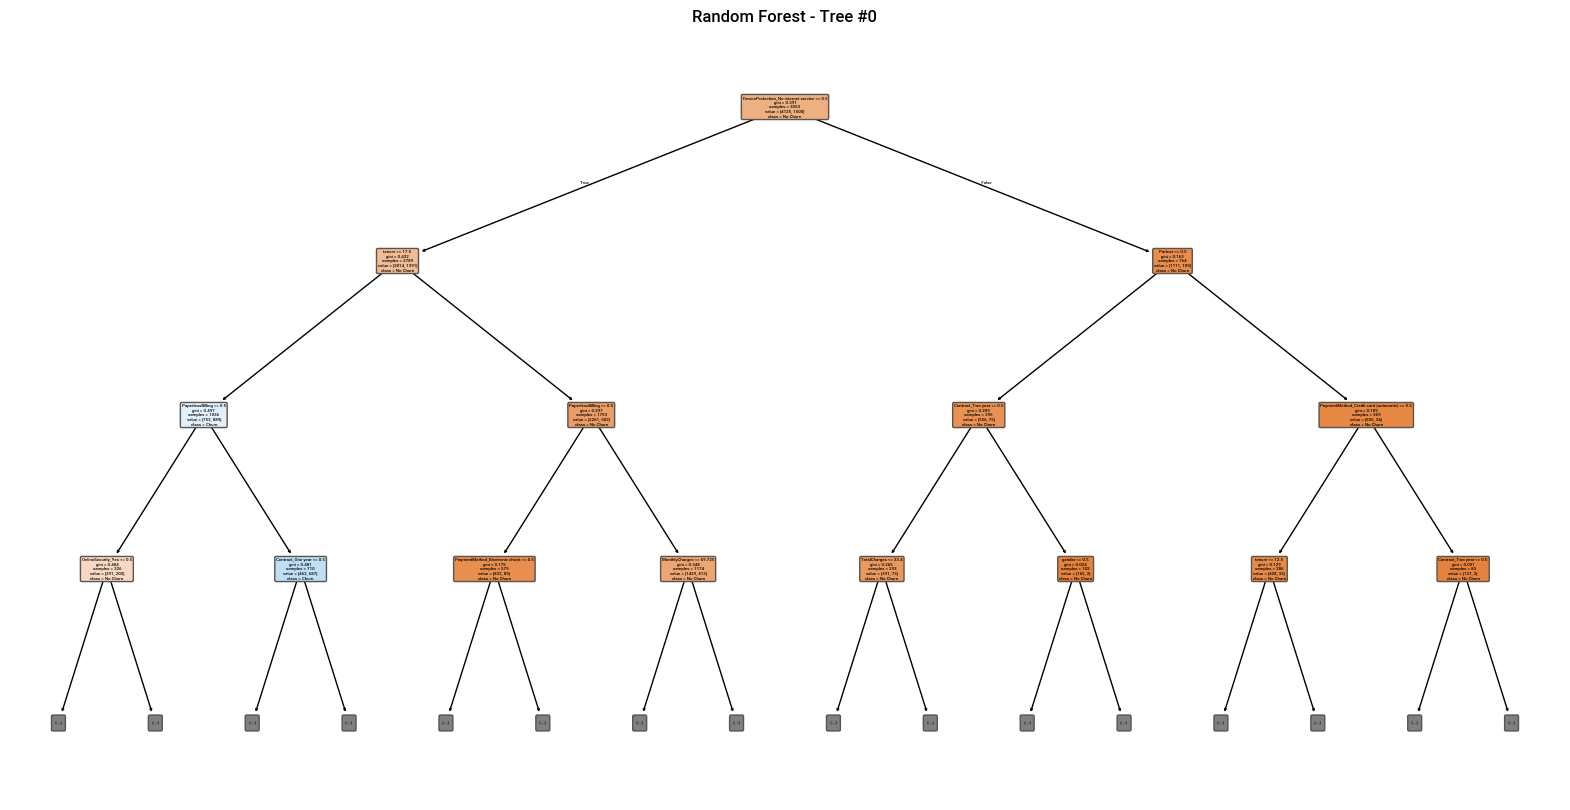

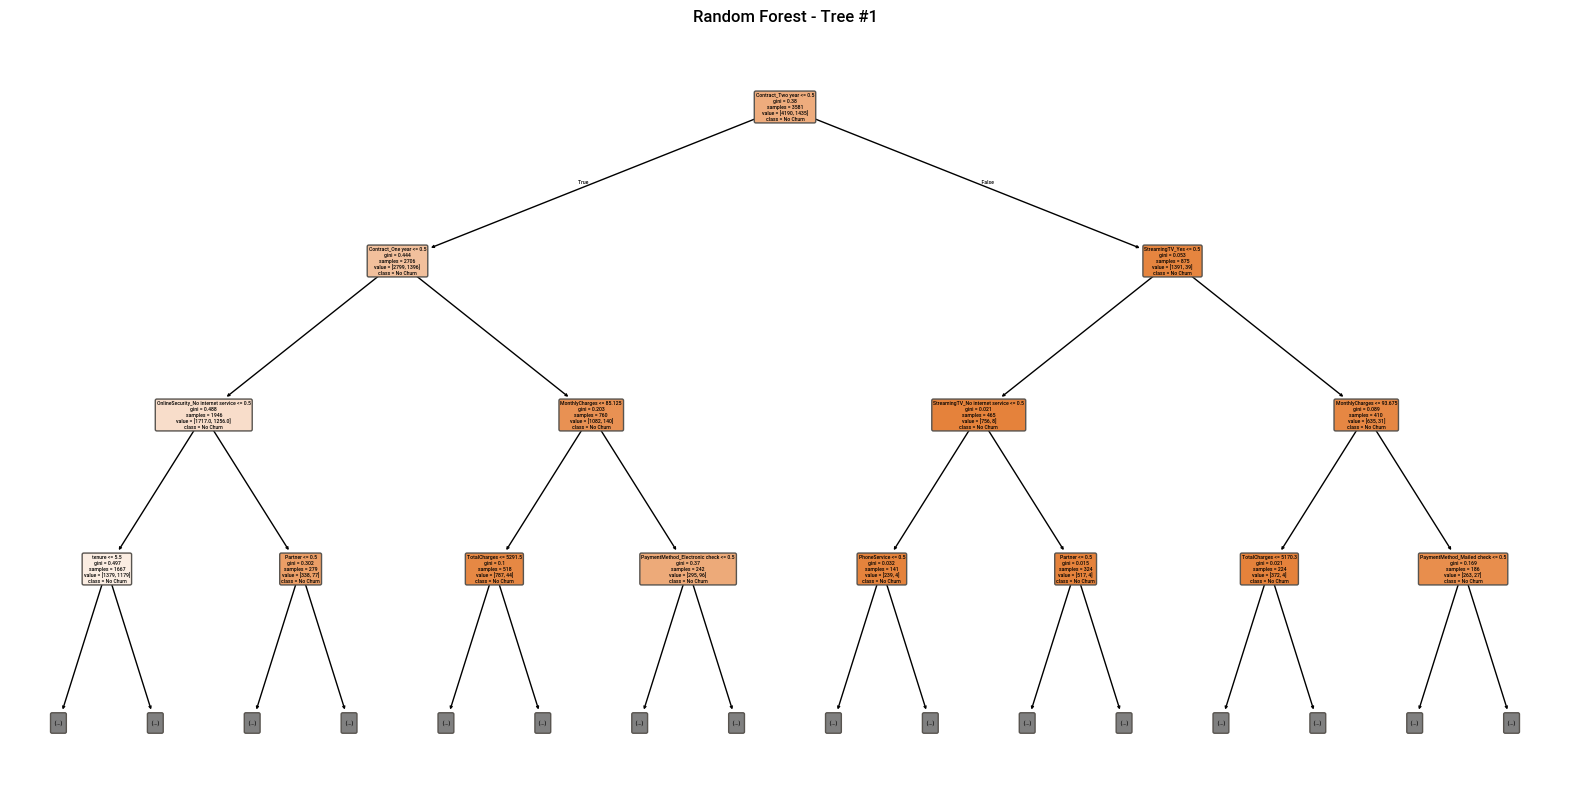

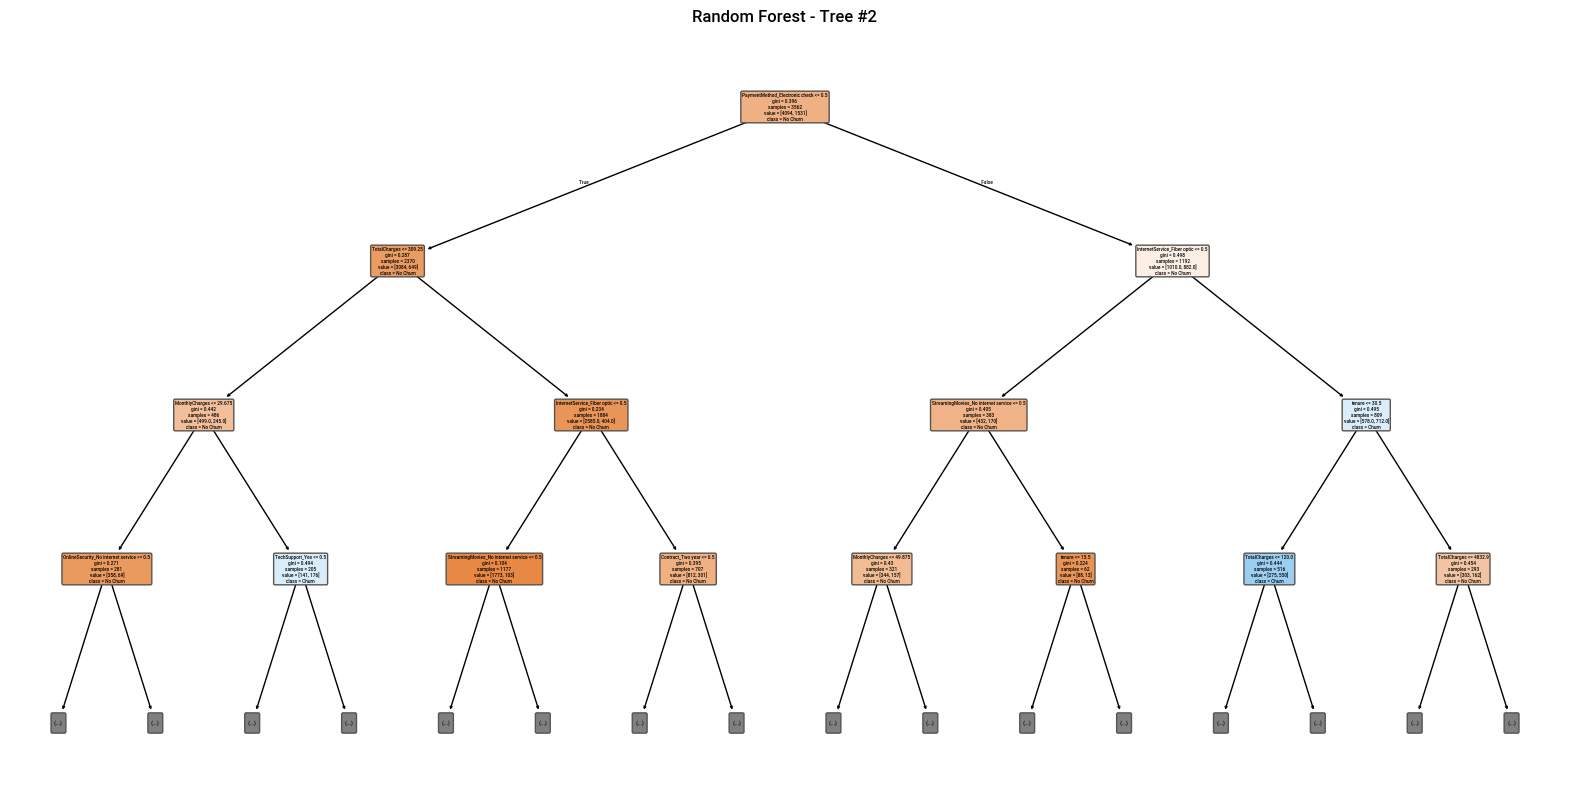

In [35]:
# Loop through the first 3 trees
for i in range(3):  # You can increase to 5, 10, etc.
    estimator = rf.estimators_[i]
    plt.figure(figsize=(20, 10))
    plot_tree(estimator,
              feature_names=X.columns,
              class_names=["No Churn", "Churn"],
              filled=True,
              rounded=True,
              max_depth=3)  # Limit depth for readability
    plt.title(f"Random Forest - Tree #{i}")
    plt.show()

In [26]:
pip install ydata-profiling

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.1/400.1 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 21.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.0 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=46c141ff04c35c34267c9970a203aab444639fa728209dd14364cb90d3f2264b
  Stored in directory: /root/.cache/pip/wheels/8d/55/1a/19cd535375ed1ede0c996405ebffe34b196d78e2d9545723a2
Successfully built htmlmin


In [27]:
from ydata_profiling import ProfileReport

In [28]:
profile = ProfileReport(df, title="Telco Customer Churn - YData Profile", explorative=True)
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 31/31 [00:00<00:00, 32.52it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

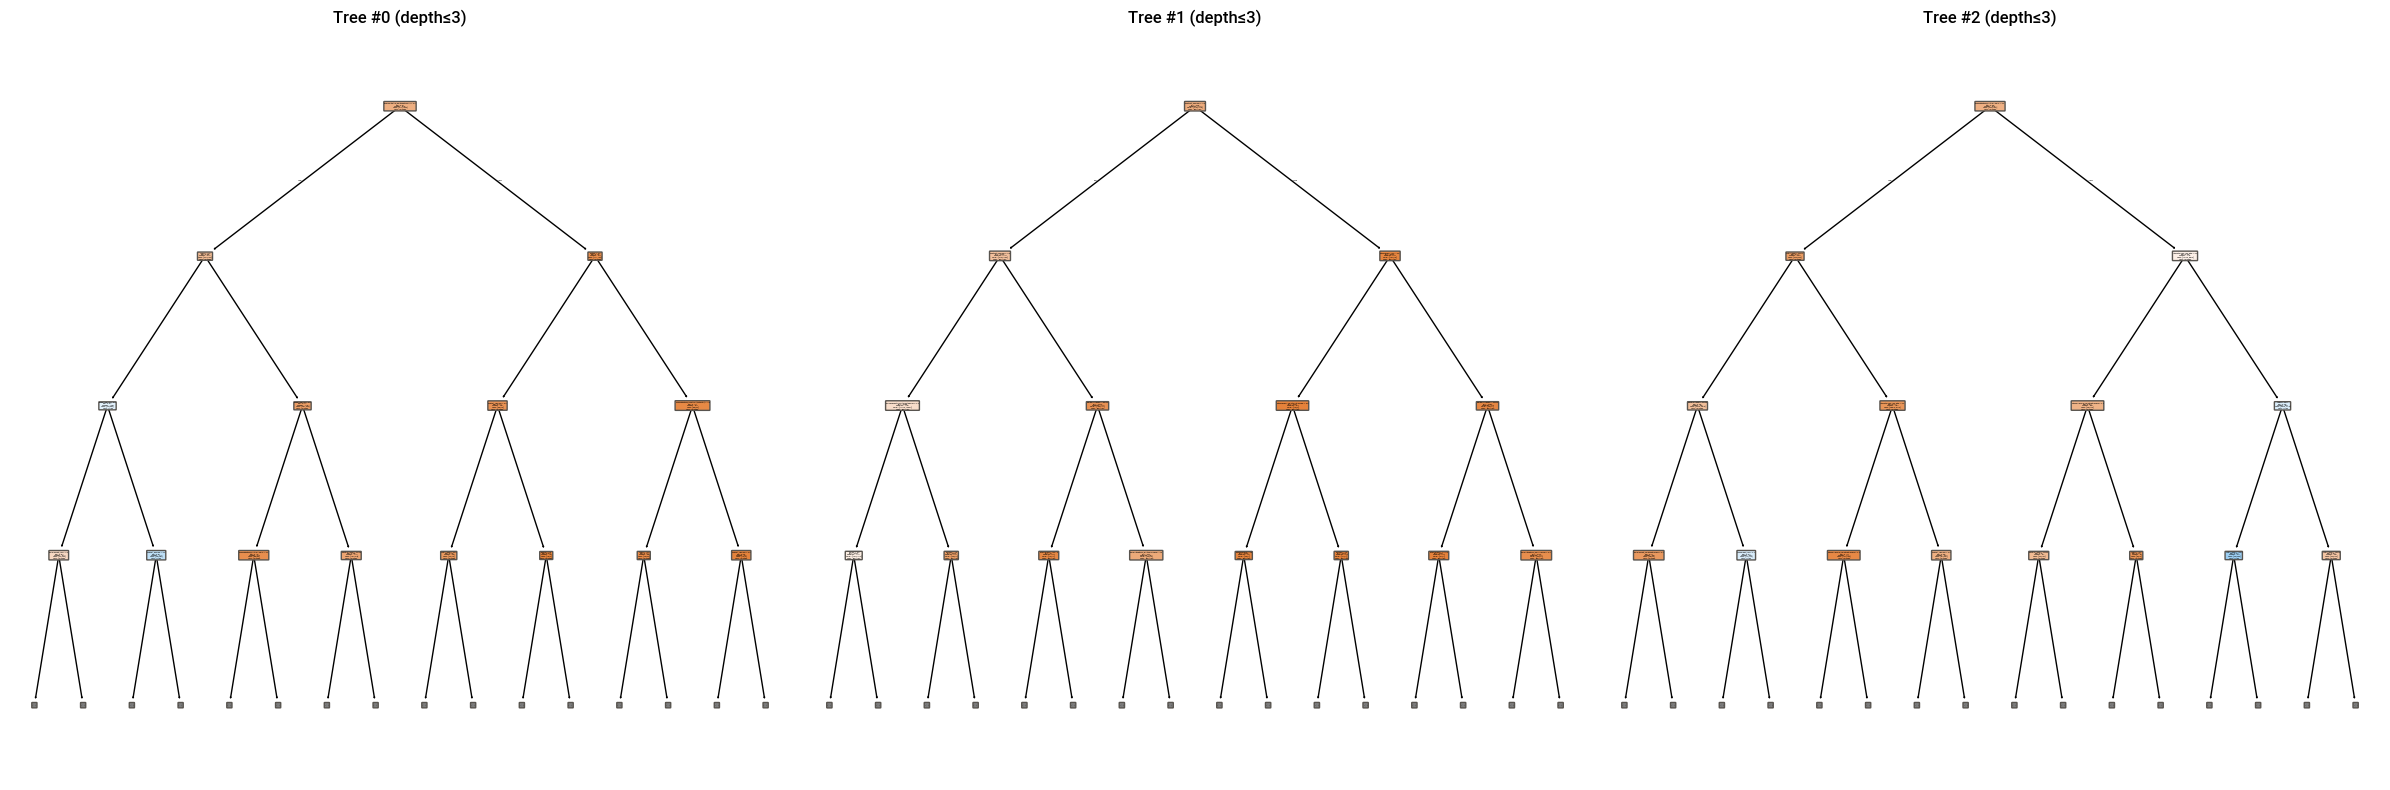

In [36]:
# Number of trees you want to visualize
n_trees = 3  # You can change this
max_depth = 3  # Limit depth for readability

# Create subplots with side-by-side layout
fig, axes = plt.subplots(1, n_trees, figsize=(24, 8))

for i in range(n_trees):
    estimator = rf.estimators_[i]
    plot_tree(estimator,
              feature_names=X.columns,
              class_names=["No Churn", "Churn"],
              filled=True,
              rounded=True,
              max_depth=max_depth,
              ax=axes[i])
    axes[i].set_title(f"Tree #{i} (depth≤{max_depth})")

plt.tight_layout()
plt.show()